In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, LinearConstraint
from tqdm import tqdm
import torch
import torch.nn as nn
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from src.cstr import *
from src.machinelearning import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
df = generate_training_data(samples=10000)
X = df[['w1', 'Cb']].values
y = df['Cb_next'].values

100%|██████████| 10000/10000 [00:00<00:00, 82856.01it/s]


In [65]:
model = SVR(kernel='rbf', C=10).fit(X, y)

In [66]:
# model = NeuralNet(2,1).to(device)
# model = train_nn(model, X, y, 5000)

In [67]:
Cb_ref = np.array([20.9 if t < 20 else 21.0 if t < 40 else 20.5 for t in range(L)])

In [68]:
Cb_res, w1_res = simulation(model, Cb_ref)

100%|██████████| 60/60 [00:10<00:00,  5.76it/s]


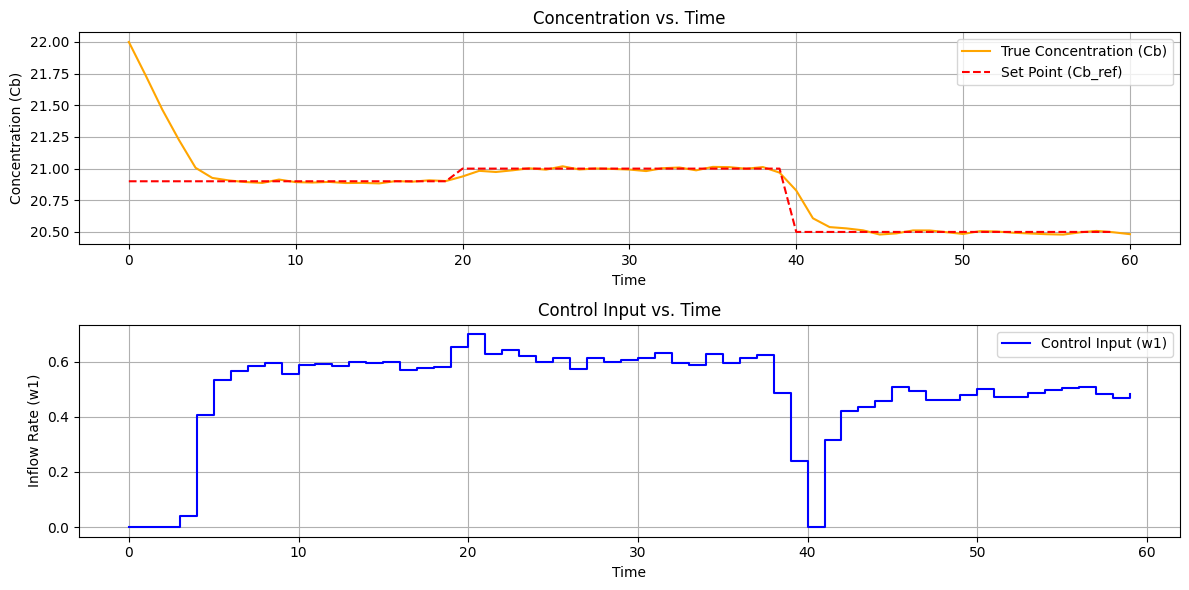

In [69]:
plot_results(Cb_res, Cb_ref, w1_res)

In [70]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the system of ODEs
def cstr_odes(y, t, w1, w2, Cb1, Cb2, k1, k2):  # Added k1, k2 to arguments
    h, Cb = y
    
    w1_t = np.interp(t, np.arange(len(w1)), w1)
    
    # Prevent division by zero by adding small epsilon
    h = max(h, 1e-10)
    
    dh_dt = w1_t - w2 - 0.2 * np.sqrt(max(h, 0))  # Added max to prevent negative sqrt
    dCb_dt = (Cb1 - Cb) * w1_t / h + (Cb2 - Cb) * w2 / h - k1 * Cb / (1 + k2 * Cb)**2
    return [dh_dt, dCb_dt]

# Initial conditions and parameters
h0 = 12.0    # initial height
Cb0 = 22.0   # initial concentration
w2 = 0.1     # flow rate 2
Cb2 = 0.1    # Concentration of stream 2
Cb1 = 24.9  # Concentration of stream 1
k1 = 1.0     # Reaction rate constant
k2 = 1.0     # Reaction parameter

# Define simulation length and time vector
t = np.arange(0, L, 1)

# Solve the ODEs
sol = odeint(cstr_odes, [h0, Cb0], t, args=(w1_res, w2, Cb1, Cb2, k1, k2))

# use discretize_solution to get the reference solution
h_res, Cb_res = discretize_solution(h0, Cb0, w1_res, w2, Cb1, Cb2, k1, k2)

# Plot results
plt.figure(figsize=(12, 4))
plt.plot(t, sol[:, 1], label='ODE')
plt.plot(t, Cb_ref, label='Reference')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'discretize_solution' is not defined